In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks");

!pip show equinox || echo equinox not found. Installing... && pip install equinox 2> /dev/null

Name: equinox
Version: 0.11.2
Summary: Elegant easy-to-use neural networks in JAX.
Home-page: 
Author: 
Author-email: Patrick Kidger <contact@kidger.site>
License: Apache License
                           Version 2.0, January 2004
                        http://www.apache.org/licenses/

   TERMS AND CONDITIONS FOR USE, REPRODUCTION, AND DISTRIBUTION

   1. Definitions.

      "License" shall mean the terms and conditions for use, reproduction,
      and distribution as defined by Sections 1 through 9 of this document.

      "Licensor" shall mean the copyright owner or entity authorized by
      the copyright owner that is granting the License.

      "Legal Entity" shall mean the union of the acting entity and all
      other entities that control, are controlled by, or are under common
      control with that entity. For the purposes of this definition,
      "control" means (i) the power, direct or indirect, to cause the
      direction or management of such entity, whether by cont

In [10]:
import jax
import equinox as eqx

class FourierEncoding(eqx.Module):
    B: jax.Array

    @property
    def num_fourier_features(self) -> int:
        return self.B.shape[0]

    @property
    def in_size(self) -> int:
        return self.B.shape[1]
    
    @property
    def out_size(self) -> int:
        return self.B.shape[0] * 2

    def __init__(self, 
                 in_size: int, 
                 num_fourier_features: int, 
                 key: jax.random.PRNGKey, 
                 sigma: float = 1.0):
        self.B = jax.random.normal(
            key, shape=(num_fourier_features, in_size),
            dtype=jax.numpy.float32) * sigma
    
    def __call__(self, x: jax.Array, **kwargs) -> jax.Array:
        return jax.numpy.concatenate(
            [jax.numpy.cos(jax.numpy.dot(self.B, x)),
             jax.numpy.sin(jax.numpy.dot(self.B, x))],
            axis=0)
    

def train_pinn(
        loss,
        fourier_mlp,
        key,
        optimizer,
        filter_spec,
        Lx=1.0,
        Ly=1.0,
        num_collocation_residual=512,
        num_iter=10_000,
        freq=1,
    ):

    # this is new
    def new_loss(diff_model, static_model, x, y):
        comb_model = eqx.combine(diff_model, static_model)
        return loss(comb_model, x, y)

    @eqx.filter_jit
    def step(opt_state, model, xs, ys):
        # added this line
        diff_model, static_model = eqx.partition(model, filter_spec)
        # changed the loss to the new loss
        value, grads = eqx.filter_value_and_grad(new_loss)(diff_model, static_model, xs, ys)
        updates, opt_state = optimizer.update(grads, opt_state)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, value
    
    opt_state = optimizer.init(eqx.filter(fourier_mlp, eqx.is_inexact_array))
    
    losses = []
    for i in range(num_iter):
        key1, key2, key = jrandom.split(key, 3)
        xb = jrandom.uniform(key1, (num_collocation_residual,), maxval=Lx)
        yb = jrandom.uniform(key2, (num_collocation_residual,), maxval=Ly)
        fourier_mlp, opt_state, value = step(opt_state, fourier_mlp, xb, yb)
        if i % freq == 0:
            losses.append(value)
            print(f"Step {i}, residual loss {value:.3e}")
    return fourier_mlp, losses

# Energy Functionals

In this notebook, we are still working with the steady-state heat equation:

\begin{aligned}
    -k\Delta u(x, y) &= f(x, y) \quad \text{in} \quad \Omega = [0, L_x]\times [0, L_y], \\
    u(x, y) &= 0 \quad \text{on} \quad \partial \Omega.
\end{aligned}

Before, we parameterized the solution so that it satisfied the boundary conditions.
Then, we constructed a loss function using the residual of the PDE.

If we forget about the parameterization for a moment, we can think of the integrated squared residual of the PDE as a function that takes a candidate solution to the PDE and returns a scalar:

$$
R[u] = \int_{\Omega} \left[ -k\Delta u(x, y) - f(x, y) \right]^2 \, dx \, dy.
$$

Such a function is called a \emph{functional}.

It turns out that for the steady-state heat equation, there is a much much better functional. It is called the \emph{energy functional} and is defined as:

$$
E[u] = \int_{\Omega} \left[ \frac{k}{2}|\nabla u(x, y)|^2 - f(x, y)u(x, y) \right] \, dx \, dy.
$$

Here are some good things about this functional:

+ A function that minimizes $E[u]$ is a solution to the PDE. We will show this.
+ Only a first derivative of $u$ appears in the integrand. This means that our function lives in the Sobolev space $W^{1, 2}(\Omega)$ instead of $W^{2, 2}(\Omega)$. This means that we could even use a ReLU network to represent the solution to the PDE.
+ The functional $E[u]$ has a unique minimizer in $W^{1, 2}(\Omega)$, among the functions that satisfy the boundary conditions. 

```{note}
The Sobolev space $W^{1, 2}(\Omega)$ is the space of functions whose first derivatives are square-integrable. The space $W^{2, 2}(\Omega)$ is the space of functions whose second derivatives are square-integrable.
Learn more about Sobolev spaces [here](https://en.wikipedia.org/wiki/Sobolev_space).
```

To show that a function that minimizes $E[u]$ is a solution to the PDE, we will use the concept of the functional derivative.
A functional derivative is a generalization of the derivative of a function to functionals.
It is defined as:

$$
\frac{\delta E[u]}{\delta v} = \lim_{\epsilon \to 0} \frac{E[u + \epsilon v] - E[u]}{\epsilon} = \frac{d}{d\epsilon}E[u + \epsilon v] \bigg|_{\epsilon = 0}
$$

where $v$ is a function in $W_0^{1, 2}(\Omega)$.
The subscript $0$ in $W_0^{1, 2}(\Omega)$ means that the functions in the space are zero on the boundary of $\Omega$.
We also call $\frac{\delta E[u]}{\delta v}$ the \emph{functional derivative} of $E[u]$ with respect to $u$ in the direction of $v$.
Another name for the functional derivative is the \emph{first variation} of $E[u]$ at $u$ in the direction of $v$.

There is a theorem that says that if a function $u$ minimizes $E[u]$, then the functional derivative of $E[u]$ at $u$ in the direction of $v$ is zero for all $v$ in $W_0^{1, 2}(\Omega)$.
We prove this in the lecture.
Here, let's find the first variation of $E[u]$ at $u$ in the direction of $v$.
We have:

\begin{align*}
\frac{\delta E[u]}{\delta v} &= \frac{d}{d\epsilon}E[u + \epsilon v] \bigg|_{\epsilon = 0} \\
&= \frac{d}{d\epsilon}\int_{\Omega} \left[ \frac{k}{2}|\nabla (u + \epsilon v)|^2 - f(u + \epsilon v) \right] \, dx \, dy \bigg|_{\epsilon = 0} \\
&= \int_{\Omega} \frac{d}{d\epsilon}\left[ \frac{k}{2}|\nabla (u + \epsilon v)|^2 - f(u + \epsilon v) \right]\bigg|_{\epsilon = 0} \, dx \, dy  \\
&= \int_{\Omega}
\frac{d}{d\epsilon}\left[ \frac{k}{2}(\nabla u + \epsilon \nabla v)\cdot (\nabla u + \epsilon \nabla v) - f(u + \epsilon v) \right]\bigg|_{\epsilon = 0} \, dx \, dy  \\
&= \int_{\Omega}
\frac{d}{d\epsilon}\left[ \frac{k}{2}(\nabla u\cdot \nabla u + 2\epsilon \nabla u\cdot \nabla v + \epsilon^2 \nabla v\cdot \nabla v) - f(u + \epsilon v) \right]\bigg|_{\epsilon = 0} \, dx \, dy  \\
&= \int_{\Omega}
\left[ k\nabla u\cdot \nabla v - fv \right] \, dx \, dy. \\
\end{align*}

Now, we integrate by parts to get:

\begin{align*}
\frac{\delta E[u]}{\delta v} &= \int_{\Omega}
\left[ k\nabla u\cdot \nabla v - fv \right] \, dx \, dy \\
&= \int_{\Omega}
\left[ -\nabla \cdot (k\nabla u) - f \right]v \, dx \, dy \\
&= \int_{\Omega}
\left[ -k\Delta u - f \right]v \, dx \, dy.
\end{align*}

If this is zero for all $v$ in $W_0^{1, 2}(\Omega)$, the part of the integrand that multiplies $v$ must be zero.
So, $u$ must satisfy the PDE.

To show that the functional $E[u]$ has a unique minimizer in $W^{1, 2}(\Omega)$, we would have to find the second variation of $E[u]$ at $u$ in the direction of $v$ and show that it is strongly positive.
We will do this in the lecture.

# Non-dimensionalizing the Energy Functional

We scale everything like we did before:

\begin{align*}
x &\mapsto \tilde{x} = \frac{x}{L_x}, \\
y &\mapsto \tilde{y} = \frac{y}{L_y}, \\
u &\mapsto \tilde{u} = \frac{u}{u_s}, \\
f &\mapsto \tilde{f} = \frac{f}{f_s}. \\
\end{align*}

We can now directly make the change on the energy functional:

\begin{align*}
E[u] &= L_xL_y\int_{\tilde{\Omega}} \left\{ \frac{1}{2}\left[\frac{ku_s^2}{L_x^2}\left(\frac{\partial \tilde{u}}{\partial \tilde{x}}\right)^2 + \frac{ku_s^2}{L_y^2}\left(\frac{\partial \tilde{u}}{\partial \tilde{y}}\right)^2\right] - f_su_s\tilde{f}\tilde{u} \right\} \, d\tilde{x} \, d\tilde{y} \\
&= L_xL_yf_su_s \int_{\tilde{\Omega}} \left\{ \frac{1}{2}\left[\frac{ku_s}{L_x^2f_s}\left(\frac{\partial \tilde{u}}{\partial \tilde{x}}\right)^2 + \frac{ku_s}{L_y^2f_s}\left(\frac{\partial \tilde{u}}{\partial \tilde{y}}\right)^2\right] - \tilde{f}\tilde{u} \right\} \, d\tilde{x} \, d\tilde{y} \\
&= L_xL_yf_su_s \int_{\tilde{\Omega}} \left\{ \frac{1}{2}\left[k_x\left(\frac{\partial \tilde{u}}{\partial \tilde{x}}\right)^2 + k_y\left(\frac{\partial \tilde{u}}{\partial \tilde{y}}\right)^2\right] - \tilde{f}\tilde{u} \right\} \, d\tilde{x} \, d\tilde{y}, \\
&= L_xL_yf_su_s \tilde{E}[\tilde{u}],
\end{align*}

where we have defined $k_x = \frac{ku_s}{L_x^2f_s}$ and $k_y = \frac{ku_s}{L_y^2f_s}$.

We pick

Now, we will pick $u_s$ to make the two terms inside $\tilde{E}[\tilde{u}]$ have the same order of magnitude.
So, we pick:

\begin{align*}
&\left\|k_x\left(\frac{\partial \tilde{u}}{\partial \tilde{x}}\right)^2+ k_y\left(\frac{\partial \tilde{u}}{\partial \tilde{y}}\right)^2\right\|_{\infty} = \|\tilde{f}\tilde{u}\|_{\infty}, \\
&\implies
\frac{ku_s}{f_s} \left\|\left(L_x^{-2}\frac{\partial \tilde{u}}{\partial \tilde{x}}\right)^2+ L_y^{-2}\left(\frac{\partial \tilde{u}}{\partial \tilde{y}}\right)^2\right\|_{\infty} = \|\tilde{f}\tilde{u}\|_{\infty}, \\
&\implies
u_s = \frac{f_s}{k}\|\tilde{f}\tilde{u}\|_{\infty}\left\|L_x^{-2}\left(\frac{\partial \tilde{u}}{\partial \tilde{x}}\right)^2+ L_y^{-2}\left(\frac{\partial \tilde{u}}{\partial \tilde{y}}\right)^2\right\|_{\infty}^{-1}.
\end{align*}

At the same time, we want to make both terms to be of order one.
This can be achieved by picking:

$$
\|\tilde{f}\tilde{u}\|_{\infty} = 1.
$$

or

$$
f_s = \|f(\tilde{x}L_x, \tilde{y}L_y)\tilde{u}\|_{\infty}.
$$

Okay, let's do it.

Start with our problem definition:

In [131]:
import jax.numpy as jnp

u0 = 500 # degrees Kelvin
k = 10.0 # thermal conductivity in W/mK
Lx = 0.1 # meters
Ly = 1.0 # meters

f = lambda x, y: 2.0 * jnp.pi ** 2 * k * u0 * (
    -Lx ** 2 * jnp.sin(jnp.pi * x / Lx) ** 2 * jnp.cos(2.0 * jnp.pi * y / Ly)
    -Ly ** 2 * jnp.sin(jnp.pi * y / Ly) ** 2 * jnp.cos(2.0 * jnp.pi * x / Lx)
) / (Lx ** 2 * Ly ** 2)

Some of the scaling:

In [132]:
to_x = lambda xt: xt * Lx
to_y = lambda yt: yt * Ly
to_xt = lambda x: x / Lx
to_yt = lambda y: y / Ly

For $u_s$, we need to parameterize the field:

In [200]:
# Make our model
import jax
import jax.random as jrandom
key = jrandom.PRNGKey(0)

key1, key2, key = jrandom.split(key, 3)
num_fourier_features = 100
width = 256
depth = 4
model = eqx.nn.Sequential([
    FourierEncoding(2, num_fourier_features, key1),
    eqx.nn.MLP(2 * num_fourier_features, 'scalar', width, depth, jax.nn.tanh, key=key2),
])
ut = lambda xt, yt, model: xt * (1 - xt) * yt * (1 - yt) * model(jnp.array([xt, yt]))

Some code to calculate infinity norms of functions using points:

In [201]:
jit_vmap = lambda g: jit(vmap(g, in_axes=(0, 0)))
infinity_norm = lambda g, xs, ys: jnp.max(jnp.abs(jit_vmap(g)(xs, ys)))

Now, we can find $f_s$:

In [211]:
from jax import vmap, jit

xs = jnp.linspace(0, Lx, 100)
ys = jnp.linspace(0, Ly, 100)
X, Y = jnp.meshgrid(xs, ys)
Xt = to_xt(X)
Yt = to_yt(Y)
Xt_flat = Xt.flatten()
Yt_flat = Yt.flatten()

fs = infinity_norm(lambda xt, yt: f(to_x(xt), to_y(yt)) * ut(xt, yt, model), Xt_flat, Yt_flat)

# The scaled version of the source
ft = lambda xt, yt: f(to_x(xt), to_y(yt)) / fs

print(f"fs = {fs:.3e}")

fs = 1.364e+04


And we can find $u_s$:

In [212]:
term1 = jit(vmap(lambda xt, yt: jnp.abs(ft(xt, yt) * ut(xt, yt, model)), in_axes=(0, 0)))(Xt_flat, Yt_flat).max()

from jax import grad
ut_x = grad(ut, 0)
ut_y = grad(ut, 1)
term2 = infinity_norm(lambda xt, yt: ut_x(xt, yt, model) ** 2 / Lx ** 2 + ut_y(xt, yt, model) **2 / Ly ** 2, Xt_flat, Yt_flat)

us = (fs * term1) / (k * term2)

print(f"us = {us:.3e}")

us = 6.414e+04


Now, we can define the scaled energy thermal conductivity:

In [213]:
kx = (k * us) / (Lx ** 2  * fs)
ky = (k * us) / (Ly ** 2  * fs)

print(f"kx = {kx:.3e}, ky = {ky:.3e}")

kx = 4.702e+03, ky = 4.702e+01


Let's verify that we have the proper scaling:

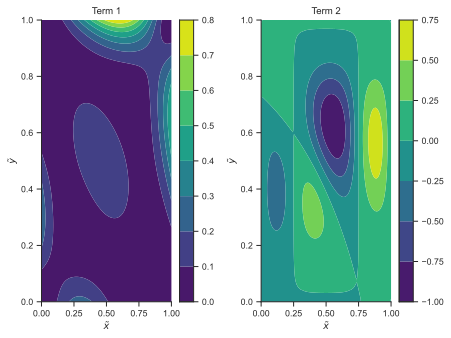

In [214]:
tE_term1 = jit(vmap(lambda xt, yt: 0.5 * (kx * ut_x(xt, yt, model) ** 2 + kx * ut_y(xt, yt, model) ** 2), in_axes=(0, 0)))
tE_term2 = jit(vmap(lambda xt, yt: ft(xt, yt) * ut(xt, yt, model), in_axes=(0, 0)))


fig, ax = plt.subplots(1,2)
trm1 = tE_term1(Xt_flat, Yt_flat).reshape(X.shape)
c = ax[0].contourf(Xt, Yt, trm1, cmap='viridis')
fig.colorbar(c, ax=ax[0])
ax[0].set_xlabel(r'$\tilde{x}$')
ax[0].set_ylabel(r'$\tilde{y}$')
ax[0].set_title('Term 1')

trm2 = tE_term2(Xt_flat, Yt_flat).reshape(X.shape)
c = ax[1].contourf(Xt, Yt, trm2, cmap='viridis')
fig.colorbar(c, ax=ax[1])
ax[1].set_xlabel(r'$\tilde{x}$')
ax[1].set_ylabel(r'$\tilde{y}$')
ax[1].set_title('Term 2')

sns.despine(trim=True)
plt.tight_layout();

We will take this. It looks good. Notice that the scaling is completely different from before.

## Training the Network

Let's make our new loss:

In [215]:
energy_loss = vmap(
    lambda xt, yt, model: 0.5 * (kx * ut_x(xt, yt, model) ** 2 + ky * ut_y(xt, yt, model) ** 2) - ft(xt, yt) * ut(xt, yt, model),
    in_axes=(0, 0, None),
)
pinn_loss = lambda model, xt, yt: jnp.mean(energy_loss(xt, yt, model))


In [216]:
import optax
import jax.tree_util as jtu

# Here, I am actually optimizing the Fourier coefficients
filter_spec = jtu.tree_map(lambda _: True, model)

key, subkey = jax.random.split(key)
optimizer = optax.adam(1e-3)
trained_model, losses = train_pinn(
    pinn_loss, model, subkey, optimizer, filter_spec,
    num_collocation_residual=256, num_iter=5_000, freq=100, Lx=1.0, Ly=1.0)

Step 0, residual loss 1.035e-01
Step 100, residual loss -2.370e-01
Step 200, residual loss -2.250e-01
Step 300, residual loss -1.002e-01
Step 400, residual loss -3.273e-01
Step 500, residual loss -2.182e-01
Step 600, residual loss -1.557e-01
Step 700, residual loss -2.311e-01
Step 800, residual loss -2.145e-01
Step 900, residual loss -2.937e-01
Step 1000, residual loss -3.032e-02
Step 1100, residual loss -3.340e-01
Step 1200, residual loss -2.046e-01
Step 1300, residual loss -1.865e-01
Step 1400, residual loss -1.772e-01
Step 1500, residual loss -3.224e-01
Step 1600, residual loss -3.415e-01
Step 1700, residual loss -1.926e-01
Step 1800, residual loss -2.110e-01
Step 1900, residual loss -3.176e-01
Step 2000, residual loss -4.067e-01
Step 2100, residual loss -2.817e-01
Step 2200, residual loss -2.407e-01
Step 2300, residual loss -2.483e-01
Step 2400, residual loss -3.020e-01
Step 2500, residual loss -2.907e-01
Step 2600, residual loss -2.233e-01
Step 2700, residual loss -1.766e-01
Step 

Let's look at the evolution of the energy functional during training:

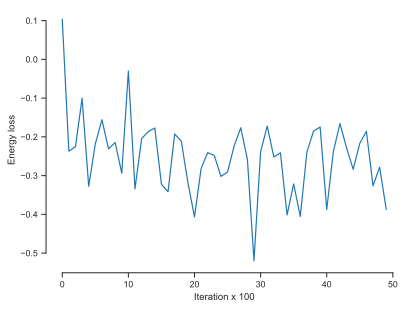

In [217]:
fig, ax = plt.subplots()
ax.plot(losses)
ax.set_xlabel('Iteration x 100')
ax.set_ylabel('Energy loss')
sns.despine(trim=True);

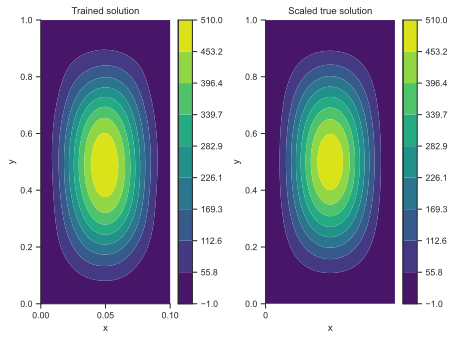

In [218]:
u_true = u0 * jnp.sin(jnp.pi * X / Lx) ** 2 * jnp.sin(jnp.pi * Y / Ly) ** 2

vtu = jit(vmap(lambda xt, yt: ut(xt, yt, trained_model)))
u_pred = vtu(Xt_flat, Yt_flat).reshape(X.shape) * us

fig, ax = plt.subplots(1,2)
c = ax[0].contourf(X, Y, u_pred, cmap='viridis',
    levels=jnp.linspace(-1, 510.0, 10))
fig.colorbar(c, ax=ax[0])
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].set_title('Trained solution')
sns.despine(trim=True);

c = ax[1].contourf(X, Y, u_true, cmap='viridis',
    levels=jnp.linspace(-1, 510.0, 10))
fig.colorbar(c, ax=ax[1])
ax[1].set_xlabel('x')
ax[1].set_ylabel('y')
ax[1].set_title('Scaled true solution')
sns.despine(trim=True)
plt.tight_layout();

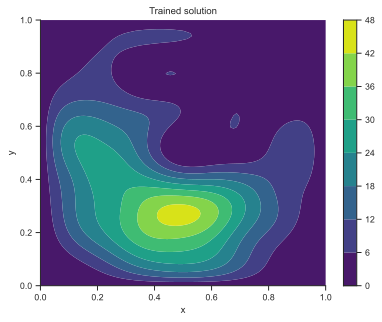

In [219]:
fig, ax = plt.subplots()
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Trained solution')
c = ax.contourf(to_xt(X), to_yt(Y), jnp.abs(u_pred - u_true), cmap='viridis')
plt.colorbar(c, ax=ax)
sns.despine(trim=True);

It is actually not as accurate as the residual loss.
It probably needs more iterations to converge.
The structure and optimization parameters were optimized for the integrated residual loss.